# Всем AI



Задача, где надо спрогнозировать класс называется классификацией (неожиданное название). Задача, где надо спрогнозировать непрерывную переменную называется регрессией. Пример непрерывной переменной: цена на квартиры. Именно её прогнозированием мы сегодня и займёмся.

# Предобработка данных 

Начнём наш крестовый поход за дешёвой недвижимостью с предобработки данных. 

In [1]:
import pandas as pd               # уже знакомый вам пакет для работы с таблицами
import numpy as np                # смутно знакомый вам пакет для работы с матрицами
import matplotlib.pyplot as plt   # уже смутно знакомый вам пакет для картинок
import seaborn as sns             # ещё один пакет для картинок 

%matplotlib inline

In [2]:
df = pd.read_csv('flat.csv', sep='\t', index_col='n')  # подгружаем табличку 
print('Размер выборки:', df.shape)                     # смотрим на её размеры 
df.head() # Смотрим что лежит в табличке 

Размер выборки: (2040, 10)


,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code
n,,,,,,,,,,
1,81,58,40,6.0,12.5,7,1,1,1,3
2,75,44,28,6.0,13.5,7,1,0,1,6
3,128,70,42,6.0,14.5,3,1,1,1,3
4,95,61,37,6.0,13.5,7,1,0,1,1
5,330,104,60,11.0,10.5,7,0,1,1,3


__Описание переменных:__

```
n – номер квартиры по порядку
price – цена квартиры в $1000
totsp – общая площадь квартиры, кв.м.
livesp жилая площадь квартиры, кв.м.
kitsp – площадь кухни, кв.м.
dist – расстояние от центра в км.
metrdist – расстояние до метро в минутах
walk – 1 – пешком от метро, 0 – на транспорте
brick 1 – кирпичный, монолит ж/б, 0 – другой
floor 1 – этаж кроме первого и последнего, 0 – иначе.
code – число от 1 до 8, при помощи которого мы группируем наблюдения по
подвыборкам:
1. Наблюдения сгруппированы на севере, вокруг Калужско-Рижской линии
метрополитена
2. Север, вокруг Серпуховско-Тимирязевской линии метрополитена
3. Северо-запад, вокруг Замоскворецкой линии метрополитена
4. Северо-запад, вокруг Таганско-Краснопресненской линии метрополитена
5. Юго-восток, вокруг Люблинской линии метрополитена
6. Юго-восток, вокруг Таганско-Краснопресненской линии метрополитена
7. Восток, вокруг Калиниской линии метрополитена
8. Восток, вокруг Арбатско-Покровской линии метрополитена
```


🤔 **Какие переменный категориальные? Какие непрерывные?**

In [3]:
# Посмотрим как они считались
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2040 entries, 1 to 2040
Data columns (total 10 columns):
price       2040 non-null int64
totsp       2040 non-null int64
livesp      2040 non-null int64
kitsp       2040 non-null float64
dist        2040 non-null float64
metrdist    2040 non-null int64
walk        2040 non-null int64
brick       2040 non-null int64
floor       2040 non-null int64
code        2040 non-null int64
dtypes: float64(2), int64(8)
memory usage: 175.3 KB


Немного кунгфу чтобы сделать данные понятнее

In [4]:
# создадим таблицу с расшифровками
codes = [
    (1, "Калужско-Рижская"),
    (2, "Серпуховско-Тимирязевская"),
    (3, "Северо-запад, Замоскворецкая"),
    (4, "Северо-запад, Таганско-Краснопресненская"),
    (5, "Юго-восток, Люблинская"),
    (6, "Юго-восток, Таганско-Краснопресненская"),
    (7, "Восток, Калиниская"),
    (8, "Восток, Арбатско-Покровская")]

codes_df = pd.DataFrame(codes, columns=['code', 'region_name'])
codes_df

# присоединим к нашим данным
df = df.merge(codes_df, on='code')
df.head(3)

,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code,region_name
0,81,58,40,6.0,12.5,7,1,1,1,3,"Северо-запад, Замоскворецкая"
1,128,70,42,6.0,14.5,3,1,1,1,3,"Северо-запад, Замоскворецкая"
2,330,104,60,11.0,10.5,7,0,1,1,3,"Северо-запад, Замоскворецкая"


# Дискриптивный анализ

In [5]:
df.describe()

,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code
count,2040.000000,2040.000000,2040.000000,2040.000000,2040.000000,2040.000000,2040.000000,2040.000000,2040.000000,2040.000000
mean,127.496569,73.084314,46.337255,8.898529,11.015686,8.117157,0.685784,0.323039,0.790686,4.322059
std,51.878220,15.123450,7.894348,2.787073,3.375539,3.815574,0.464317,0.467752,0.406918,2.183289
min,50.000000,44.000000,28.000000,5.000000,3.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,95.000000,62.000000,42.000000,7.000000,9.000000,5.000000,0.000000,0.000000,1.000000,3.000000
50%,115.000000,73.500000,45.000000,9.000000,12.000000,7.000000,1.000000,0.000000,1.000000,4.000000
75%,142.000000,79.000000,50.000000,10.000000,13.500000,10.000000,1.000000,1.000000,1.000000,6.000000
max,730.000000,192.000000,102.000000,25.000000,17.000000,20.000000,1.000000,1.000000,1.000000,8.000000


Пропусков нет. Это хорошая новость.

🤔 **А что делать, если бы они были?**

In [6]:
# Есть ли в переменных пропуски?
df.isnull().sum()

price          0
totsp          0
livesp         0
kitsp          0
dist           0
metrdist       0
walk           0
brick          0
floor          0
code           0
region_name    0
dtype: int64

## Целевая переменная

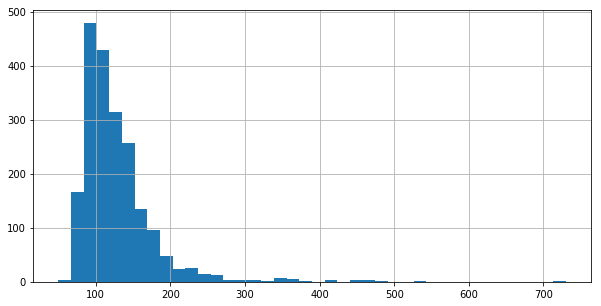

In [7]:
df.price.hist(bins=40, figsize=(10,5))
# в долларах не очень понятно

In [8]:
# посчитайте цену в млн. рублей
# пусть новая колонка называется "price_rur", а курс доллара ₽75

# ( ͡° ل͜ ͡°)━☆ﾟ.*･｡ﾟ☆ﾟ.*･｡ﾟ

# ✅ SOLUTION:
df['price_rur'] = df.price*75/1000

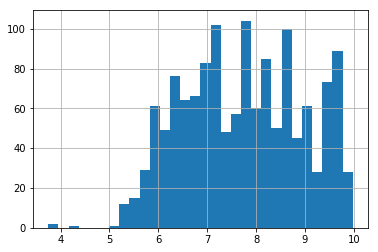

In [9]:
df.loc[df.price_rur<10, 'price_rur'].hist(bins=30)

In [10]:
# дешевых квартир в наших данных мало
# почему? ну такие данные)))
df[df.price_rur<5]

,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code,region_name,price_rur
348,56,68,43,7.0,13.5,10,0,1,1,6,"Юго-восток, Таганско-Краснопресненская",4.20
1619,52,86,46,9.0,12.0,10,0,0,1,7,"Восток, Калиниская",3.90
1624,50,63,47,7.0,12.0,20,0,1,0,7,"Восток, Калиниская",3.75


## Зависимая переменная

In [11]:
# постройте распрделение площади квартир
# 🤔 Какие выводы можно сделать по этой визуализации?

# ( ͡° ل͜ ͡°)━☆ﾟ.*･｡ﾟ☆ﾟ.*･｡ﾟ

In [12]:
# постройте распределение удаленности от метро
# 🤔 Какие выводы можно сделать по этой визуализации?

# ( ͡° ل͜ ͡°)━☆ﾟ.*･｡ﾟ☆ﾟ.*･｡ﾟ

## Статистики по регионам

In [13]:
# сгруппируем по 'region_name'
# посчитаем средние значения для остальных полей
# 🤔 Какие выводы можно сделать по этой таблице?

df.groupby('region_name').mean()

,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code,price_rur
region_name,,,,,,,,,,,
"Восток, Арбатско-Покровская",136.744444,72.350000,47.794444,8.519444,8.952778,7.944444,0.777778,0.605556,0.727778,8.0,10.255833
"Восток, Калиниская",114.230088,70.650442,45.070796,8.185841,10.090708,9.132743,0.561947,0.327434,0.747788,7.0,8.567257
Калужско-Рижская,134.411765,72.687500,46.316176,9.084559,10.808824,8.628676,0.750000,0.338235,0.838235,1.0,10.080882
"Северо-запад, Замоскворецкая",148.246377,76.950725,48.930435,9.272464,11.317391,8.382609,0.547826,0.510145,0.791304,3.0,11.118478
"Северо-запад, Таганско-Краснопресненская",148.693780,74.712919,47.449761,9.253589,9.344498,6.822967,0.708134,0.330144,0.856459,4.0,11.152033
Серпуховско-Тимирязевская,110.316279,68.018605,43.465116,8.079070,13.753488,7.939535,0.804651,0.134884,0.739535,2.0,8.273721
"Юго-восток, Люблинская",115.779762,75.696429,45.684524,9.781250,11.748512,7.886905,0.752976,0.136905,0.818452,5.0,8.683482
"Юго-восток, Таганско-Краснопресненская",109.964981,70.466926,45.322957,8.334630,11.198444,7.949416,0.642023,0.249027,0.774319,6.0,8.247374


# Модель решающего дерева

Замоделируем цену квартиры - построим модель оценки стоимости жилья в зависимости от его характеристик. **Модель** - это некоторая функция перехода от $X$ к $y$

$$f(X) -> y, $$

где $X$ - независимые переменные, $y$ - зависимая переменная

## Как строится решающее дерево
В дереве строится набор разбиений по разным признакам, посмотрим на примере

### разбиение 1: 
есть гипотеза, что квартиры с меньшей площадью стоят дешевле

In [108]:
# разобьем на два подмножества по этому признаку
threshold = 60
leaf_left = df[df.totsp < threshold]
leaf_right = df[df.totsp >= threshold]

Оценим что получилось

Средняя стоимость в левом листе 6.7 млн.
Средняя стоимость в правом листе 10.1 млн.


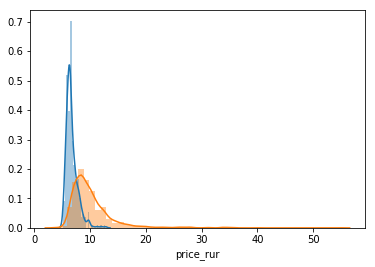

In [136]:
print("Средняя стоимость в левом листе {:.3} млн.".format(leaf_left.price_rur.mean()))
print("Средняя стоимость в правом листе {:.3} млн.".format(leaf_right.price_rur.mean()))

# построим распределние цен
sns.distplot(leaf_left.price_rur)
sns.distplot(leaf_right.price_rur)

### разбиение 2: 
есть гипотеза, что квартиры, находящиеся ближе к метро, стоят дороже

In [126]:
# разобьем на два подмножества по этому признаку

threshold = 5
# левый лист
leaf_left_left = leaf_left[leaf_left.dist < threshold]
leaf_left_right = leaf_left[leaf_left.dist >= threshold]

# правый лист
leaf_right_left = leaf_right[leaf_right.dist < threshold]
leaf_right_right = leaf_right[leaf_right.dist >= threshold]

Оценим что получилось

Если от начала пошли в левый лист

Средняя стоимость в левом листе 8.25 млн.
Средняя стоимость в правом листе 6.56 млн.


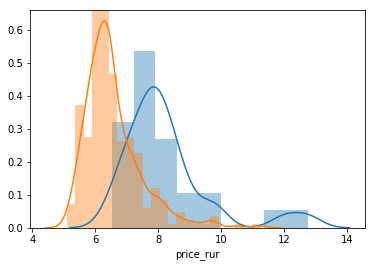

In [137]:
print("Если от начала пошли в левый лист\n")
print("Средняя стоимость в левом листе {:.3} млн.".format(leaf_left_left.price_rur.mean()))
print("Средняя стоимость в правом листе {:.3} млн.".format(leaf_left_right.price_rur.mean()))

# построим распределние цен для разбиений в левом листе
sns.distplot(leaf_left_left.price_rur)
sns.distplot(leaf_left_right.price_rur)

Если от начала пошли в правый лист

Средняя стоимость в левом листе 13.0 млн.
Средняя стоимость в правом листе 9.93 млн.


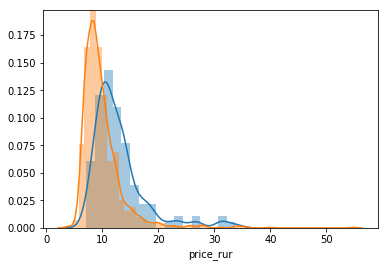

In [138]:
print("Если от начала пошли в правый лист\n")
print("Средняя стоимость в левом листе {:.3} млн.".format(leaf_right_left.price_rur.mean()))
print("Средняя стоимость в правом листе {:.3} млн.".format(leaf_right_right.price_rur.mean()))

# построим распределние цен для разбиений в левом листе
sns.distplot(leaf_right_left.price_rur)
sns.distplot(leaf_right_right.price_rur)

### Получили вот такое решающее дерево - можно строить до необходимой глубины, увеличивая точность

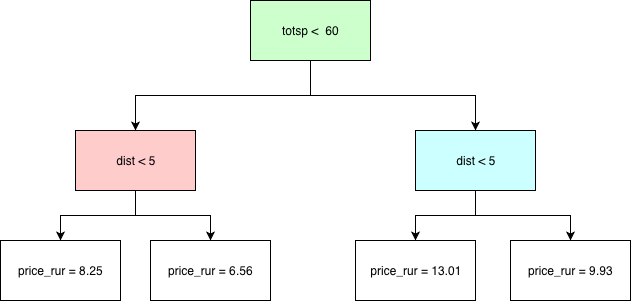

## Обучаем модель

In [14]:
# импортируем модель
# моделирование живет в библиотеке sklearn
# в частности, нас интересуют решающее дерево

from sklearn.tree import DecisionTreeRegressor

In [15]:
model = DecisionTreeRegressor()

In [16]:
# вспомним какие у нас вообще данные
df.columns

Index(['price', 'totsp', 'livesp', 'kitsp', 'dist', 'metrdist', 'walk',
       'brick', 'floor', 'code', 'region_name', 'price_rur'],
      dtype='object')

In [17]:
# зависимая переменная
y = df['price_rur']
y.head()

0     6.075
1     9.600
2    24.750
3    16.875
4     9.900
Name: price_rur, dtype: float64

In [18]:
# независимые переменные
features_list = ['totsp', 'livesp', 'kitsp', 'dist', 'metrdist', 'walk', 'brick', 'floor', 'code']
X = df[features_list]
X.head()

,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code
0,58,40,6.0,12.5,7,1,1,1,3
1,70,42,6.0,14.5,3,1,1,1,3
2,104,60,11.0,10.5,7,0,1,1,3
3,80,56,9.0,9.0,5,1,1,1,3
4,96,56,12.0,10.5,7,0,0,1,3


In [19]:
# учим модель
model.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

# И что с этим теперь делать?
предсказывать цены на квартиры!

In [20]:
# возьмем любую квартиру из данных, хоть две,
# отберем нужные признаки

flat = df.loc[[0, 800], ['totsp', 'livesp', 'kitsp', 'dist',
                  'metrdist', 'walk', 'brick', 'floor', 'code']]
flat

,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code
0,58,40,6.0,12.5,7,1,1,1,3
800,61,38,8.0,12.0,15,1,0,1,1


In [21]:
# применим модель

predicted_price = model.predict(flat)
predicted_price

array([6.075, 7.35 ])

In [22]:
# а какая цена была на самом деле?

real_price = df.loc[[0, 800], ['price_rur']]
real_price

,price_rur
0,6.075
800,7.350


# Простейшая оценка точности алгоритма

Как формализовать понятие точности работы модели?

Познакомимся с метрикой MAE (mean absolute error), средняя абсолютная ошибка. Она вычисляется следующим образом: 

$$ MAE = \frac{1}{n}\sum_{i=1}^{n} |y_i - \hat{y}_i|. $$

Если мы спрогнозировали, что квартира стоит 20 рублей, а она стоила 10 рублей, мы ошиблись на |10 - 20| = 10 рублей. Средняя абсолютная ошибка - это средняя сумма рублей, на которую мы ошиблись.

In [23]:
from sklearn.metrics import mean_absolute_error

predicted_price = model.predict(df[features_list])
real_price = df['price_rur']
error = mean_absolute_error(predicted_price, real_price)
error*1_000_000

13786.764705882357

Получается у нас модель в среднем ошибается на 13 тысяч?

Как бы это правильно проверить?

Давайте разбираться...

# Валидация

Валидация - это процесс оценки адекватности модели. Здесь мы проверим как модель ведет себя на ранее неизвестных данных

Для этого поделим данные на тренировочные и тестовые:
- $30\%$ данных откладываем для тестирования качества модели
- остальные $70\%$ берём для обучения. 

In [24]:
# в библиотеке для моделирования идем в model_selection
# там лежат разные методы для тестиоования моделей, достаем нужный
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.3, random_state=1)

In [25]:
# Посмотрим на размеры трэйна и теста

print(df_train.shape)
print(df_test.shape)

(1428, 12)
(612, 12)


In [26]:
# Вытаскиваем цены и параметры квартир по разным переменным для удобства 

y_train = df_train['price_rur'] 
y_test = df_test['price_rur']

X_train = df_train[features_list]
X_test = df_test[features_list]

In [27]:
# обучаем

model.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [28]:
# проверяем точность на тестовых данных

error = mean_absolute_error(model.predict(X_test), y_test)
print("В среднем дерево ошибается на {:.2} млн".format(error))
print("не так плохо при средней стоимости квартиры в {:.2} млн.".format(df.price_rur.mean()))

В среднем дерево ошибается на 1.4 млн
не так плохо при средней стоимости квартиры в 9.6 млн.


Часто для нас принципиальным является не то, на сколько денег мы ошиблись, а то на сколько процентов мы ошиблись. Метрика, которая отлавливает процентную ошибку, называется MAPE (mean absolute percentage error), средняя абсолютная процентная ошибка. 

$$
MAPE = \frac{1}{n} \sum_{i=1}^n \frac{|y_i - \hat{y}_i|}{y_i}
$$

Она часто применяется в следующих задачах: например, вы прогнозируете спрос, и вам принципиально, на сколько процентов вы ошиблись, а не абсолютное значение. Если вы предсказали  один, а в реальности было  десять - это не то же самое, что вы предсказали  тысяча, а в реальности было  тысяча  девять. С точки зрения МАЕ или MSE, это две совершенно одинаковые ошибки. А если вас интересует, сколько в среднем на сколько процентов вы ошибаетесь, то это отражает МАРЕ.

Её нам придётся реальзовать самостоятельно. Благо, это не очень трудно. 

In [29]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(model.predict(X_test), y_test)
print("Относительная ошибка = {:.4}%".format(mape))

Относительная ошибка = 13.64%


# Посмотрим, что за модель мы получили

In [41]:
pd.DataFrame(model.feature_importances_, index=features_list,
             columns=['Значимость признаков в модели'])\
.sort_values('Значимость признаков в модели', ascending=False)

,Значимость признаков в модели
totsp,0.536667
livesp,0.197953
dist,0.121238
metrdist,0.046834
code,0.039656
kitsp,0.031317
walk,0.011941
brick,0.008981
floor,0.005412


# That's all, folks!